In [154]:
### Necessary Import Statements
import praw
import config

# Data Collection

In [155]:
reddit = praw.Reddit(
    client_id=config.client_id,
    client_secret=config.client_secret,
    user_agent=config.user_agent,
)

In [156]:
print(reddit.read_only)

True


In [157]:
relevant_subreddits = ["clinicaltrials", "clinicalresearch", "medicine"]

In [158]:
for submission in reddit.subreddit("test").hot(limit=5):
    print(submission.title)

Some test commands
Test Title
Test
video test222
test


### Getting Data From Clinical Trials

In [170]:
query = "clinical trials"
subreddit = reddit.subreddit('clinicaltrials')
diff_categories = [subreddit.hot, subreddit.new, subreddit.top, subreddit.rising]

# for cat in diff_categories:
#     for post in cat(limit=None):
#         print(f"Title: {post.title}\nLink: {post.url}\n")
        
#         # Fetch and print top comments from each post
#         post.comments.replace_more(limit=None)  # Load all comments, no "more comments" links
#         for comment in post.comments.list():
#             author = comment.author
#             if author:  # Checking if the author object exists
#                 print(f"Comment by {author.name}: {comment.body}")
#                 print(f"User '{author.name}' karma: {author.comment_karma + author.link_karma}, Account created: {author.created_utc}\n")
#                 print(author)
#             else:
#                 print("Comment by [deleted]")

#         print("-" * 80)  # Separator for readability

## Getting Data and Into CSV

In [171]:
# Prepare CSV files
posts_file = open('posts.csv', 'w', newline='', encoding='utf-8')
authors_file = open('authors.csv', 'w', newline='', encoding='utf-8')
comments_file = open('comments.csv', 'w', newline='', encoding='utf-8')

In [172]:
import csv 

# Create CSV writers
posts_writer = csv.writer(posts_file, quoting=csv.QUOTE_ALL)
authors_writer = csv.writer(authors_file, quoting=csv.QUOTE_ALL)
comments_writer = csv.writer(comments_file, quoting=csv.QUOTE_ALL)

# Write headers
posts_writer.writerow(['post_id', 'title', 'selftext', 'url', 'score', 'created_utc', 'author_id'])
authors_writer.writerow(['author_id', 'username', 'karma', 'account_created'])
comments_writer.writerow(['comment_id', 'body', 'post_id', 'author_id'])

# Used to store authors to avoid duplicate entries in authors.csv
authors_set = set()

In [177]:
from datetime import datetime

try:
    for cat in diff_categories:
        for post in cat(limit=None):
            if post.author and post.author.name not in authors_set:
                # Write author data
                if getattr(post.author, 'id', None) is None:
                    continue
                authors_writer.writerow([post.author.id, post.author.name, post.author.comment_karma + post.author.link_karma,
                            datetime.fromtimestamp(post.author.created_utc).isoformat()])        
                authors_set.add(post.author.name)
            
            # Write post data
            posts_writer.writerow([
                post.id, post.title, post.selftext.replace('\n', ' '), post.url, post.score,
                datetime.fromtimestamp(post.created_utc).isoformat(), post.author.id if post.author else None
            ])

            # Process comments
            post.comments.replace_more(limit=None)
            for comment in post.comments.list():
                if comment.author and comment.author.name not in authors_set:
                    # Write author data
                    if getattr(comment.author, 'id', None) is None:
                        continue
                    authors_writer.writerow([comment.author.id, comment.author.name, comment.author.comment_karma + comment.author.link_karma, datetime.fromtimestamp(comment.author.created_utc)])
                    authors_set.add(comment.author.name)
                
                # Write comment data
                comments_writer.writerow([comment.id, comment.body, post.id, comment.author.id if comment.author else None])
except:
    print("Too many requests sent!")

TooManyRequests: received 429 HTTP response

In [178]:
posts_file.close()
authors_file.close()
comments_file.close()

In [179]:
import pandas as pd

posts_df = pd.read_csv('posts.csv')
comments_df = pd.read_csv('comments.csv')
authors_df = pd.read_csv('authors.csv')

posts_with_authors = pd.merge(posts_df, authors_df, on='author_id', how='left', suffixes=('_post', '_author'))
comments_with_authors = pd.merge(comments_df, authors_df, on='author_id', how='left', suffixes=('_comment', '_author'))

combined_df = pd.concat([posts_with_authors, comments_with_authors], axis=0)

combined_df.to_csv('combined_database.csv', index=False)

print(combined_df.head())

   post_id                                              title  \
0   omqnox  Clinical Trials Discussion Thread - Week of 20...   
1  18n1cxq  Consider supporting clinical research educatio...   
2  16g6y6q  Seeking Feedback from Pregnant & Post-Partum P...   
3  104kol5  The Story of Mucinex - How a Common Drug Becam...   
4   yjiiup  Webinar Tomorrow: Hear how experiential data a...   

                                            selftext  \
0  Here you can talk about specific clinical tria...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                                 url  score  \
0  https://www.reddit.com/r/clinicaltrials/commen...    8.0   
1  /r/clinicalawareness/comments/18n1a9q/each_yea...    2.0   
2  http://www.ciscrp.org/pab-interest/?utm_source...    1.0   
3                   

In [182]:
print(len(combined_df))

366


In [185]:
combined_df['post_text'] = combined_df['title'].fillna('') + " " + combined_df['selftext'].fillna('')
combined_df['body'] = combined_df['body'].fillna('')
combined_df.to_csv("combined.csv")

# Sentiment Analysis

In [186]:
import re

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # url removal
    text = re.sub(r'/u/[^\s]+', '', text)  # user mentions
    text = re.sub(r'/r/[^\s]+', '', text)  # subreddit mentions
    text = re.sub(r'[^A-Za-z\s.,!?;:()\'\"/]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [187]:
import pandas as pd
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/manav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [188]:
sia = SentimentIntensityAnalyzer()

def calculate_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']  # Using the compound score for overall sentiment

combined_df['sentiment'] = combined_df['post_text'].apply(calculate_sentiment)

if 'body' in combined_df.columns:
    combined_df['body'] = combined_df['body'].apply(clean_text)  # Clean the comments
    combined_df['comment_sentiment'] = combined_df['body'].apply(calculate_sentiment)

combined_df.to_csv('processed_sentiment.csv', index=False)

print(combined_df.head())

   post_id                                              title  \
0   omqnox  Clinical Trials Discussion Thread - Week of 20...   
1  18n1cxq  Consider supporting clinical research educatio...   
2  16g6y6q  Seeking Feedback from Pregnant & Post-Partum P...   
3  104kol5  The Story of Mucinex - How a Common Drug Becam...   
4   yjiiup  Webinar Tomorrow: Hear how experiential data a...   

                                            selftext  \
0  Here you can talk about specific clinical tria...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                                 url  score  \
0  https://www.reddit.com/r/clinicaltrials/commen...    8.0   
1  /r/clinicalawareness/comments/18n1a9q/each_yea...    2.0   
2  http://www.ciscrp.org/pab-interest/?utm_source...    1.0   
3                   

In [189]:
result_df = combined_df.groupby('author_id').agg({
    'karma': 'first',  # Assuming karma is constant per author_id
    'post_text': ' '.join,  # Concatenate all texts together
    'body': ' '.join,
    'sentiment': 'mean',  # Average post sentiment
    'comment_sentiment': 'mean'  # Average comment sentiment
}).reset_index()

In [190]:
result_df.to_csv("results.csv")

In [191]:
result_df.head(20)

,author_id,karma,post_text,body,sentiment,comment_sentiment
0,10m3i3,181.0,,The simple answer is yes. Have you looked at t...,0.000000,0.401900
1,12qo9x,2402.0,,,0.000000,0.000000
2,14ux3r,25.0,,What an excellent post. About the only thing I...,0.000000,0.727500
3,16hf0dts,6856.0,,Great clinical research center: Nucleus Networ...,0.000000,0.757900
4,17emvc,2077.0,Thoughts on this Clinical Trial on Prostate En...,All of the above if posible! Or any feedback ...,0.000000,0.228700
5,1fvxtsg5,3043.0,,Do clinical trials care if you smoke weed? Do ...,0.000000,0.493900
6,28cclhhq,290.0,Types and phases of clinical trials There are ...,,0.954700,0.000000
7,2ebpmkmg,2.0,Are you experiencing poor sleep during the ong...,,0.318200,0.000000
8,2ghtugb7,1.0,,"New study from Labcorp Dallas, TX for Males, a...",0.000000,0.546100
9,2hekytbi,1.0,Clinical Trial for healthy Males/Females in Sa...,,0.401900,0.000000


In [192]:
# result_df["net_sentiment"] = result_df["sentiment"] - result_df["comment_sentiment"]
# result_df = result_df.sort_values("net_sentiment", ascending=False)
# result_df

In [193]:
result_df['combined_sentiment'] = result_df.apply(lambda row: (row['sentiment'] + row['comment_sentiment']) / 2 
                                    if pd.notnull(row['post_text']) and pd.notnull(row['body']) 
                                    else row['sentiment'] if pd.notnull(row['post_text']) 
                                    else row['comment_sentiment'], axis=1)
result_df = result_df.sort_values("combined_sentiment")
result_df

,author_id,karma,post_text,body,sentiment,comment_sentiment,combined_sentiment
24,7l9ag0zm,81.0,Research Study for Co-occurring Chronic Pain a...,,-0.852100,0.000000,-0.426050
34,avdvhtb7,53.0,Clinicial Trial for Veterans Hi everyone! The...,,-0.817200,0.000000,-0.408600
33,8o7sh1fw,1.0,Are you looking to lose weight before your nex...,,-0.781000,0.000000,-0.390500
29,8bkqkc6t,115.0,CBD RESEARCH STUDY: PTSD AND TBI (NYC) Are you...,...,-0.695374,0.000000,-0.347687
26,82roe,1136.0,,FYI: Sent to the NLM / ClinicalTrials.gov( hel...,0.000000,-0.584400,-0.292200
47,ufrr8o63,323.0,,Some do and some dont but be honest with them ...,0.000000,-0.550400,-0.275200
32,8ljjwzxh,1.0,,If a clinician puts your name and contact info...,0.000000,-0.493900,-0.246950
20,61k3hwwi,935.0,,My trial has had a rash of people canceling th...,0.000000,-0.457400,-0.228700
15,4nm6319p,14.0,,Its possible in Asia Pacific as long as your f...,0.000000,-0.401900,-0.200950
17,4x4ded8j,146.0,Covans Dallas TX Warning about this place The...,,-0.310900,0.000000,-0.155450


In [194]:
def sentiment_category(sentiment):
    if sentiment > 0.1: 
        return 'Positive'
    elif sentiment < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

result_df['sentiment_category'] = result_df['combined_sentiment'].apply(sentiment_category)

result_df.to_csv('updated_sentiment_data.csv', index=False)

In [195]:
result_df

,author_id,karma,post_text,body,sentiment,comment_sentiment,combined_sentiment,sentiment_category
24,7l9ag0zm,81.0,Research Study for Co-occurring Chronic Pain a...,,-0.852100,0.000000,-0.426050,Negative
34,avdvhtb7,53.0,Clinicial Trial for Veterans Hi everyone! The...,,-0.817200,0.000000,-0.408600,Negative
33,8o7sh1fw,1.0,Are you looking to lose weight before your nex...,,-0.781000,0.000000,-0.390500,Negative
29,8bkqkc6t,115.0,CBD RESEARCH STUDY: PTSD AND TBI (NYC) Are you...,...,-0.695374,0.000000,-0.347687,Negative
26,82roe,1136.0,,FYI: Sent to the NLM / ClinicalTrials.gov( hel...,0.000000,-0.584400,-0.292200,Negative
47,ufrr8o63,323.0,,Some do and some dont but be honest with them ...,0.000000,-0.550400,-0.275200,Negative
32,8ljjwzxh,1.0,,If a clinician puts your name and contact info...,0.000000,-0.493900,-0.246950,Negative
20,61k3hwwi,935.0,,My trial has had a rash of people canceling th...,0.000000,-0.457400,-0.228700,Negative
15,4nm6319p,14.0,,Its possible in Asia Pacific as long as your f...,0.000000,-0.401900,-0.200950,Negative
17,4x4ded8j,146.0,Covans Dallas TX Warning about this place The...,,-0.310900,0.000000,-0.155450,Negative


# Message Generation

In [196]:
from openai import OpenAI

client = OpenAI(api_key=config.api_key)

In [199]:
def advanced_personalization(messages):
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
        messages=messages,
    )
    # print(response.choices[0])
    return response.choices[0].message.content.strip()

def create_prompt(df, user_id):
  role = "Role: You are a conscientious promoter of clinical trials in Health!" 
  task = "The task is to recommend users why to paritcipate in clinical trials, you will be given a user's Reddit activity, write a personalized message for making them participate in clinical trials."
  post_text_df = str(df[df["author_id"] == user_id]["post_text"].values[0])
  comment_df = str(df[df["author_id"] == user_id]["body"].values[0])
  

  prompt = role + task
  # print("here", len(post_text_df))
  if len(post_text_df) > 1:
    # print(post_text_df)
    post_sentiment = int(df[df["author_id"] == user_id]['sentiment'].values[0])
    prompt += f"These are the Reddit posts, the user had made about Clinical Trials: \"{post_text_df}\".\n" 
    prompt += f"The sentiment of the posts where 1 being positive and -1 being negative, was: {post_sentiment}\n"
  
  # print("here")
  if len(comment_df) > 1:
    comment_sentiment = int(df[df["author_id"] == user_id]['comment_sentiment'].values[0])
    prompt += f"These are the Reddit comments to other posts that the user has made about Clinical Trials: {comment_df} \n"
    prompt += f"The sentiment of the posts where 1 being positive and -1 being negative, was: {comment_sentiment}\n"

  prompt += "What should the personalized message to this user be? Act like you are talking to that user or sending them an outreach mesaage."

  return prompt

In [200]:
# str(result_df[result_df["author_id"] == "82roe"]["post_text"].values[0])
# len(str(result_df[result_df["author_id"] == "82roe"]["post_text"].values[0]))
# user_id = "82roe"
# post_text_df = str(result_df[result_df["author_id"] == user_id]["post_text"].values[0])
# print(len(post_text_df))
# result_df[result_df["author_id" == user_id]]['sentiment']
users = set(result_df["author_id"].values)
# users

In [16]:
# result_df["prompt"] = 
responses = []
i = 0
for user_id in users:
    p = create_prompt(result_df, user_id)
    print(p)
    messages = [{"role": "user", "content": p}]
    print(p)
    response = advanced_personalization(messages)
    responses.append(response)

NameError: name 'users' is not defined

In [ ]:
combined_df["personalized_message"] = responses

## Data Analysis and Graphs

In [4]:
result_df = pd.read_csv("updated_sentiment_data.csv")

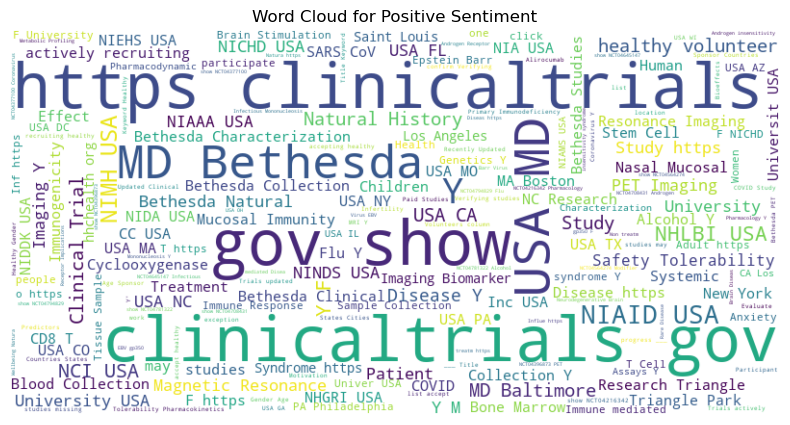

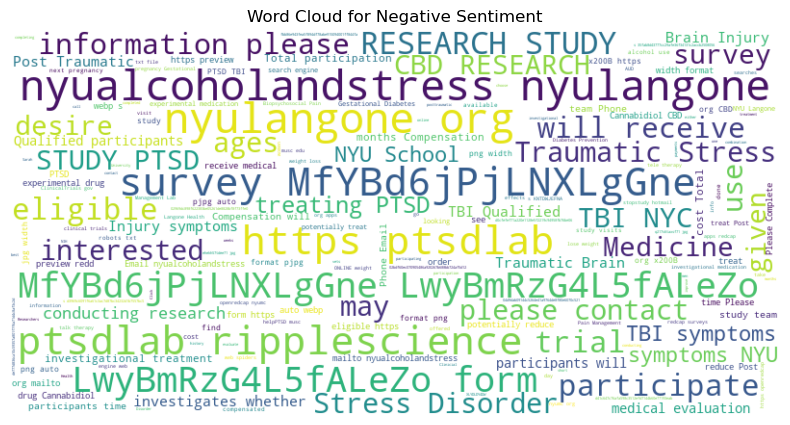

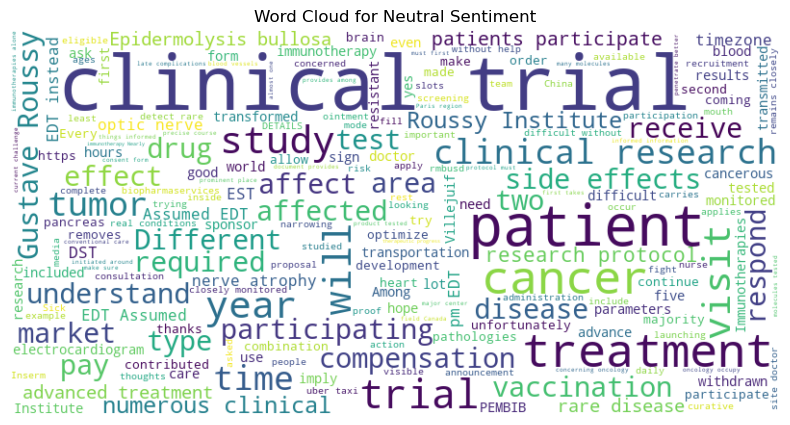

In [14]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each sentiment category
for sentiment in ['Positive', 'Negative', 'Neutral']:
    # Combine all text from posts and comments in this sentiment category
    combined_text = ' '.join(result_df[result_df['sentiment_category'] == sentiment]['post_text'].fillna('') + " " + result_df[result_df['sentiment_category'] == sentiment]['body'].fillna(''))
    # print(result_df[result_df['sentiment_category'] == sentiment])
    generate_word_cloud(combined_text, f'Word Cloud for {sentiment.capitalize()} Sentiment')

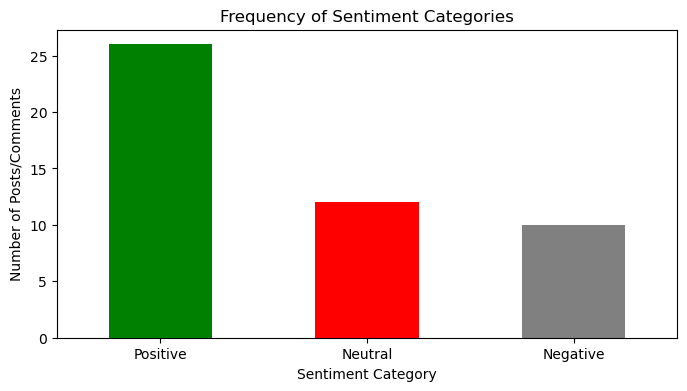

In [15]:
sentiment_counts = result_df['sentiment_category'].value_counts()

plt.figure(figsize=(8, 4))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Frequency of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Posts/Comments')
plt.xticks(rotation=0)
plt.show()